# Airline Analysis

Resources:

Economics:
http://www.oecd.org/daf/competition/airlinecompetition.htm

Graph theoretical:
https://beta.vu.nl/nl/Images/werkstuk-meer_tcm235-280356.pdf

aircraft traffic data by main airport:
https://datamarket.com/data/set/196g/aircraft-traffic-data-by-main-airport#!ds=196g!nto=6:ntp=b:ntq=3:ntr=1.1g.1u.7.z.a.j.v.1b.t.d.s.1n.12.p.8.b.y.e.19.17.1v.9.i.11.1f.1s.1a.1w.x.14.1l.1p.4.k.1r.g.1x.1c.f.15.q.1j.1t.l.1k.1h:nts=nf.rb&display=line





Loading the dataset:

In [1]:
from  geopy.distance import distance

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
!bash download_data.sh

Getting airports data
Getting airlines data
Getting routes data
Getting planes data


In [4]:
airports = pd.read_csv('airports.dat', header=None, names=
                      ["AirportID","Name", "City", "Country", "IATA", "ICAO",
                       "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabaseTimeZone",
                       "Type", "Source"],
                      na_values='\\N')
airlines = pd.read_csv('airlines.dat', header=None, names=
                       ["AirlineID", "Name", "Alias", "IATA", "ICAO", "Callsign", "Country", "Active"]
                       ,na_values='\\N')
routes = pd.read_csv('routes.dat', header=None, names=
                     ['Airline', 'AirlineID', 'SourceAirport', 'SourceAirportID', 'DestinationAirport',
                      'DestinationAirportID', 'Codeshare', 'Stops', 'Equipment'],
                    na_values='\\N')
planes = pd.read_csv('planes.dat', header=None, names=
                     ['Name', 'IATA code', 'ICAO code'])

Only keep airports in intersection:

In [5]:
valid_airports = set(airports.IATA).intersection(set(routes.SourceAirport).union(set(routes.DestinationAirport)))

In [6]:
routes = routes[routes.SourceAirport.isin(valid_airports) &  routes.DestinationAirport.isin(valid_airports)]
airports = airports[airports.IATA.isin(valid_airports)]

In [7]:
airports.IATA.unique().shape, len(set(routes.SourceAirport).union(set(routes.DestinationAirport)))

((3186,), 3179)

Only keep airports in intersection:

In [8]:
valid_airlines = set(airlines.AirlineID).intersection(set(routes.AirlineID))

In [9]:
airlines = airlines[airlines.AirlineID.isin(valid_airlines)]
routes = routes[routes.AirlineID.isin(valid_airlines)]

In [10]:
airlines.AirlineID.unique().shape, routes.AirlineID.unique().shape

((545,), (545,))

In [11]:
len(valid_airports), len(valid_airlines)

(3186, 545)

In [12]:
routes_by_airline = routes[['SourceAirport', 'DestinationAirport', 'Airline']]
routes_by_airline.drop_duplicates().shape == routes_by_airline.shape

True

In [13]:
merged_routes = pd.merge(airlines[airlines.Active == 'Y'], routes, on='AirlineID')

## TODO:
- get the distane of the edge based on longitude and latitude ✅
- add all the information to the graph so we have an easy time calculating the measures. ✅
- get list of graph theoretical measures to apply to airline networks:
    - number and strength of hubs 
    - network robustness measures
    - number of/ precense if paths
    - diameter of the graph
    - centrality measures
    - spectrum of graph
    - measure of correlation between country label
    - how much in country/out of country ✅
    - number of triangles in graph
    - set weights if we have multiple fights to same place by same airline ✅
    - get overlaping nodes functions. similarity of graph
- get planes associated with each flight in route, so we can get number of passagers. May do later only for the biggest airlines, at end of analysis ❓

In [14]:
merged_routes.head(1)

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment
0,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,FAI,3832.0,HKB,7242.0,NaN,0,CNA


In [15]:
airports.head(1)

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabaseTimeZone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports


In [16]:
airports_filtered = airports[['Name', 'Country', 'Longitude', 'Latitude', 'Timezone', 'IATA']].copy()

In [17]:
airports_filtered.dropna(inplace=True)
airports_filtered.set_index('IATA', inplace=True)

In [18]:
airports_filtered.Longitude.dropna().shape == airports_filtered.Longitude.shape

True

In [19]:
location_mapping = airports_filtered.apply(lambda x: [x.Longitude, x.Latitude], axis=1).to_dict()

In [20]:
airline_name_to_number = merged_routes.Name.drop_duplicates().reset_index(drop=True).to_dict()
airline_name_to_number = {v: k for k, v in airline_name_to_number.items()}

In [21]:
merged_routes['AirlineNbr'] = merged_routes.Name.map(airline_name_to_number)

### Getting the distance between two airports:

Example of functionality:

In [22]:
element = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[0]
element2 = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[1]

In [23]:
distance(element, element2).km

106.2489585209369

In [24]:
distance_mapping = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1).to_dict()

Getting whether the flight is international or not:

In [25]:
Airport_to_country = airports.set_index('IATA').Country.to_dict()

In [26]:
merged_routes['International'] = merged_routes.apply(
    lambda x: Airport_to_country[x.SourceAirport] == Airport_to_country[x.DestinationAirport], axis=1)

In [34]:
merged_routes

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,AirlineNbr,International,Distance
0,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,FAI,3832.0,HKB,7242.0,NaN,0,CNA,0,True,118.675035
1,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,HKB,7242.0,FAI,3832.0,NaN,0,CNA,0,True,118.675035
2,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,MRS,1353.0,NaN,0,319,1,False,767.018673
3,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,ORY,1386.0,NaN,0,319,1,False,1393.826774
4,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,CDG,1382.0,NaN,0,319,1,False,1369.896055
5,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,LIL,1399.0,NaN,0,320,1,False,1541.323265
6,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,LYS,1335.0,NaN,0,320 319,1,False,1015.406701
7,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,MRS,1353.0,NaN,0,319,1,False,768.527296
8,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,ORY,1386.0,NaN,0,320 319,1,False,1338.370829
9,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,TLS,1273.0,NaN,0,320 319,1,False,786.314943


Additing it to merged_routes:

In [27]:
merged_routes['Distance'] = merged_routes.apply(lambda x: 
                distance(distance_mapping[x.SourceAirport], distance_mapping[x.DestinationAirport]).km, axis=1)

Create graph with edge having airline associated to

In [28]:
biggest = merged_routes.AirlineNbr.value_counts().head(10).index

In [29]:
Airline_Graph = nx.from_pandas_edgelist(merged_routes[merged_routes.AirlineNbr.isin(biggest)], 
                                        source='SourceAirport', 
                                        target='DestinationAirport', 
                                        edge_attr=['Country', 'Name', 'AirlineNbr', 'Distance', 'International'])

no duplicate edges, all weights should be 1

In [30]:
routes_by_airline = merged_routes[['SourceAirport', 'DestinationAirport', 'Airline', 'Name']]
routes_by_airline.drop_duplicates().shape == routes_by_airline.shape

True

In [31]:
color_edges = list(nx.get_edge_attributes(Airline_Graph, 'AirlineNbr').values())

In [32]:
nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


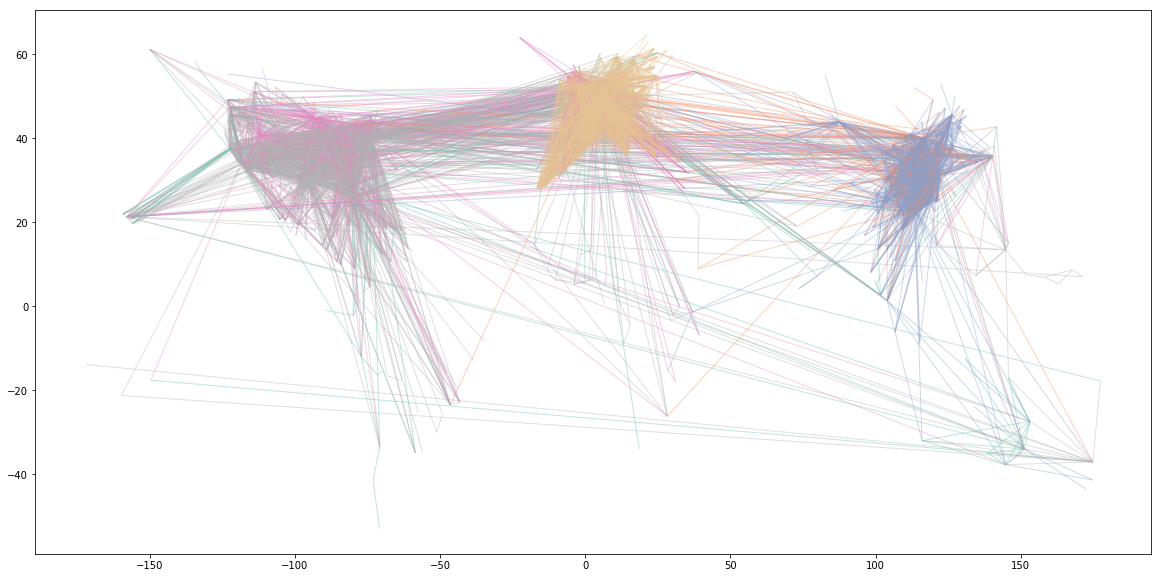

In [33]:
plt.figure(figsize=(20, 10))
nx.draw_networkx(Airline_Graph, 
                 pos=nx.get_node_attributes(Airline_Graph, 'Location'), 
                 edge_color=color_edges, edge_cmap=plt.cm.Set2, node_size=0, labels=dict(), alpha=0.4)

Example analysis of one graph:

In [ ]:
def create_airline_network(airline):
    df = merged_routes[merged_routes['Name'] == airline]
    Airline_Graph = nx.from_pandas_edgelist(df, 
                                      source='SourceAirport', target='DestinationAirport', edge_attr=['Country'])
    nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')
    return Airline_Graph

In [ ]:
Ryanair = create_airline_network('Ryanair')

In [ ]:
plt.figure(figsize=(20, 10))
nx.draw_networkx(Ryanair, 
                 pos=nx.get_node_attributes(Ryanair, 'Location'), labels=dict(), alpha=0.4)

In [ ]:
nx.node_connectivity(Ryanair)

In [ ]:
nx.degree_centrality(Ryanair)

In [ ]:
nx.average_clustering(Ryanair)

In [ ]:
nx.k_nearest_neighbors(Ryanair)

In [ ]:
nx.triangles(Ryanair)

In [ ]:
nx.diameter(Ryanair)

In [ ]:
nx.estrada_index(Ryanair)

In [ ]:
nx.eccentricity(Ryanair)

## Preliminary analysis of the biggest airports:

In [ ]:
merged_routes.Name.value_counts().head(10)

In [ ]:
Low_cost = ['Southwest Airlines', 'Virgin America', 'AirAsia', 'Ryanair','easyJet', 'WestJet', 'Pegasus Airlines', 'Spirit Airlines', 'Mango']

In [ ]:
merged_routes[merged_routes.Name.isin(Low_cost)].Name.value_counts()

In [ ]:
merged_routes.Name.value_counts().head(120).plot(kind='bar')

In [ ]:
merged_routes.Country.value_counts().head(20)

In [ ]:
merged_routes['Codeshare'] = merged_routes.Codeshare.fillna('N')

In [ ]:
merged_routes.Codeshare.value_counts()

In [ ]:
merged_routes.head()

In [ ]:
def draw_airline_network(airline):
    df = merged_routes[merged_routes['Name'] == airline]
    Airline_Graph = nx.from_pandas_edgelist(df, 
                                      source='SourceAirport', target='DestinationAirport', edge_attr=['Country'])

    plt.figure(figsize=(10, 10))
    centrality = nx.betweenness_centrality(Airline_Graph)
    size = np.array(list(centrality.values()))*1000
    nx.draw_spring(Airline_Graph, node_size=size, width=0.1)
    plt.title(airline)
    plt.show()

In [ ]:
for cheap in Low_cost:
    draw_airline_network(cheap)

In [ ]:
Best_Airlines = ['Singapore Airlines', 'Emirates', 'Lufthansa', 'Qatar Airways', 'Cathay Pacific']

In [ ]:
for best in Best_Airlines:
    draw_airline_network(best)

In [ ]:
Large_Airlines = ['Delta Air Lines', 'Air France', 'China Southern Airlines', 'Turkish Airlines', 'American Airlines']

In [ ]:
for best in Large_Airlines:
    draw_airline_network(best)

In [ ]:
merged_routes.Name.unique()

In [ ]:
Chinese = ['China Southern Airlines', 'China Eastern Airlines', 'Air China']

In [ ]:
for best in Chinese:
    draw_airline_network(best)

## Adding in external information: for relected airlines - case study

In [36]:
Delays_data = pd.read_csv('🏬 AIRLINE LIST  ✈️  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - Delays data (raw).csv')

In [44]:
Airline_list = pd.read_csv('🏬 AIRLINE LIST  ✈️  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - 🏬 Airlines.csv')

In [47]:
set(Airline_list.name.map(lambda x: x.lower())).intersection(set(merged_routes.Name.map(lambda x: x.lower())))

{'aegean airlines',
 'aer lingus',
 'aerolineas argentinas',
 'air astana',
 'air canada',
 'air china',
 'air europa',
 'air france',
 'air koryo',
 'air new zealand',
 'air transat',
 'alaska airlines',
 'alitalia',
 'allegiant air',
 'american airlines',
 'asiana airlines',
 'austrian airlines',
 'bangkok airways',
 'biman bangladesh airlines',
 'british airways',
 'cathay pacific',
 'cebu pacific',
 'china eastern airlines',
 'china southern airlines',
 'copa airlines',
 'croatia airlines',
 'czech airlines',
 'delta air lines',
 'eastar jet',
 'easyjet',
 'egyptair',
 'emirates',
 'ethiopian airlines',
 'etihad airways',
 'eurowings',
 'eva air',
 'finnair',
 'flybe',
 'frontier airlines',
 'garuda indonesia',
 'hainan airlines',
 'hawaiian airlines',
 'icelandair',
 'iran air',
 'jeju air',
 'jet airways',
 'jin air',
 'kenya airways',
 'korean air',
 'kuwait airways',
 'lufthansa',
 'luxair',
 'malaysia airlines',
 'middle east airlines',
 'nepal airlines',
 'nok air',
 'oman ai

In [42]:
merged_routes.Name.head()

0    40-Mile Air
1    40-Mile Air
2     Aigle Azur
3     Aigle Azur
4     Aigle Azur
Name: Name, dtype: object

In [48]:
set(Delays_data['On-time'].map(lambda x: x.lower())).intersection(set(merged_routes.Name.map(lambda x: x.lower())))

{'air arabia',
 'air baltic',
 'air canada',
 'air china',
 'air france',
 'airasia',
 'alitalia',
 'american airlines',
 'asiana airlines',
 'azul',
 'bangkok airways',
 'british airways',
 'cathay pacific',
 'delta air lines',
 'easyjet',
 'egyptair',
 'emirates',
 'ethiopian airlines',
 'flybe',
 'frontier airlines',
 'fuji dream airlines',
 'germanwings',
 'ibex airlines',
 'indonesia airasia',
 'jetblue airways',
 'korean air',
 'lufthansa',
 'nok air',
 'peach aviation',
 'qantas',
 'qatar airways',
 'royal jordanian',
 'singapore airlines',
 'sky airline',
 'skymark airlines',
 'southwest airlines',
 'spicejet',
 'spirit airlines',
 'srilankan airlines',
 'thai airasia',
 'turkish airlines',
 'united airlines',
 'westjet'}